In [1]:
%matplotlib inline
from fastai.basics import *

# MNIST SGD

In [3]:
path = Config().data_path()/'mnist' #mnist flattened version
path.ls()

[PosixPath('/Users/elvingomez/.fastai/data/mnist/mnist.pkl.gz')]

In [4]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
x_train.shape

(50000, 784)

This actually comes in as the shape 50,000 rows by 784 columns, but those 784 columns are actually 28 by 28 pixel pictures. So if we reshape one of them into a 28 by 28 pixel picture and plot it, then we can see it's a number:

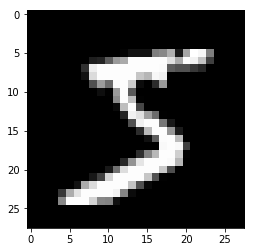

In [7]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")

In [8]:
x_train, y_train, x_valid, y_valid = map(torch.tensor,(x_train, y_train, x_valid, y_valid))
n, c = x_train.shape #n = number of things we have, c = num of columns
x_train.shape, y_train.min(), y_train.max() # y is the nums to predict

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [9]:
bs=64 #batch size
train_ds = TensorDataset(x_train, y_train) #TensorDataset grabs 2 tensor and creates a dataset
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs) #it is gonna create a data loader (iterator)
data

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x141350fd0>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x141350828>;

Test: None

In [10]:
x, y  = next(iter(data.train_dl)) #because it is a dataloader we can call next which means next batch size(64) things
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [11]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True) #nn.Linear is a linear layer, it does (a@x + b)
    def forward(self, xb): #xb stands for x-mini-batch
        return self.lin(xb) # we pass our batch of x to self.lin and that's going to give us back the result of the a@x + b on this mini batch

So this is a logistic regression model. A logistic regression model is also known as a neural net with no hidden layers, so it's a one layer neural net, no nonlinearities.


In [14]:

model = Mnist_Logistic().cuda() #Because we're doing stuff ourself a little bit we have to put the weight matrices (i.e. the parameters) onto the GPU manually(.cuda()) 

In [15]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [16]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [17]:
model(x).shape

torch.Size([64, 10])

In [ ]:
[p.shape for p in model.parameters()]

The most interesting property is the one called "parameters" which contains all of our parameters. It contains our weight matrices and bias matrices in as much as they're different. So if we have a look at p.shape for p in model.parameters(), there's something of 10 by 784, and there's something of 10. So what are they? 10 by 784 - so that's the thing that's going to take in 784 dimensional input and spit out a 10 dimensional output. That's handy because our input is 784 dimensional and we need something that's going to give us a probability of 10 numbers. After that happens we've got ten activations which we then want to add the bias to, so there we go. Here's a vector of length 10. So you can see why this model we've created has exactly the stuff that we need to do our a@x+b

In [19]:
lr=2e-2

MSE is not a good loss function for us because in our case we have, for MNIST, 10 possible digits and we have 10 activations each with a probability of that digit. So we need something where predicting the right thing correctly and confidently should have very little loss; predicting the wrong thing confidently should have a lot of loss. So that's what we want.

In [23]:
loss_func = nn.CrossEntropyLoss()

Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.

def CrossEntropy(yHat, y):
    if y == 1:
      return -log(yHat)
    else:
      return -log(1 - yHat)

In [24]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [25]:
losses = [update(x,y,lr) for x,y in data.train_dl]

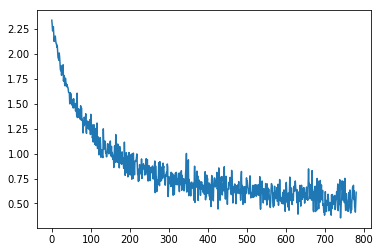

In [26]:
plt.plot(losses)

# MNIST Neural Network

In [27]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True) 
        #we need to be sure that sizes match (50 - 50 in this case), and the final layer has an output of 10 because that's the number of classes we're predicting

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)


In [28]:
model = Mnist_NN().cuda()

In [29]:
losses = [update(x,y,lr) for x,y in data.train_dl]

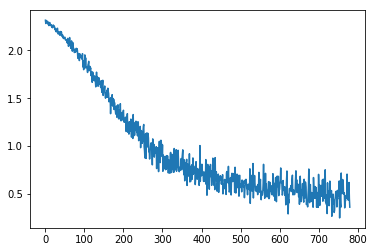

In [30]:
plt.plot(losses)

In [61]:
model = Mnist_NN().cuda()

In [62]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [63]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

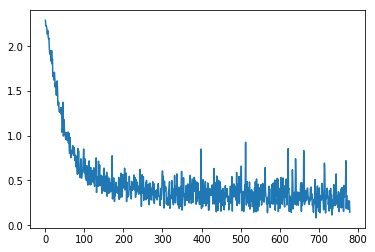

In [64]:
plt.plot(losses)

In [65]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


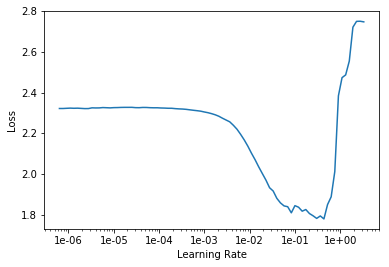

In [66]:
learn.lr_find()
learn.recorder.plot()

In [67]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.145368,0.128790,0.963600,00:01


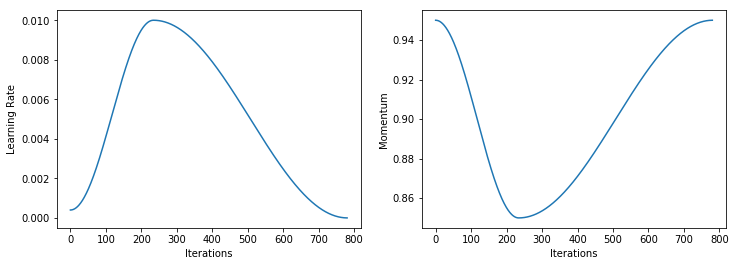

In [68]:
learn.recorder.plot_lr(show_moms=True)

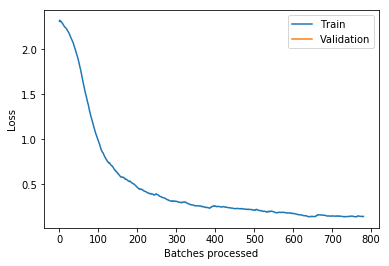

In [69]:

learn.recorder.plot_losses()